In [21]:
 # Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi 
import numpy as np

%matplotlib inline

In [22]:
 # Load .env enviroment variables
load_dotenv()

True

In [23]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
print(f"ALP Key type:{type(alpaca_secret_key)}")

ALP Key type:<class 'str'>


In [24]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [25]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2009-08-07', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-01-05', tz='America/New_York').isoformat()
timeframe='1D'

In [26]:
 # Get 5 years' worth of historical data for SPY 
tickers = ['SPY']
df_sp500_data = alpaca.get_barset(tickers, timeframe, start = start_date, end = end_date).df
# Display sample data
df_sp500_data.head()

SPY                                   
                             open    high     low   close     volume
time                                                                
2009-08-07 00:00:00-04:00  100.92  102.03  100.39  101.19  177299779
2009-08-10 00:00:00-04:00  100.77  101.22  100.27  100.96  112363486
2009-08-11 00:00:00-04:00  100.54  100.61   99.46   99.66  135460278
2009-08-12 00:00:00-04:00   99.54  101.56   99.53  100.78  189280222
2009-08-13 00:00:00-04:00  101.26  101.61  100.26  101.58  149874941

In [27]:
df_sp500_data.index=df_sp500_data.index.date
df_sp500_data.head()

SPY                                   
              open    high     low   close     volume
2009-08-07  100.92  102.03  100.39  101.19  177299779
2009-08-10  100.77  101.22  100.27  100.96  112363486
2009-08-11  100.54  100.61   99.46   99.66  135460278
2009-08-12   99.54  101.56   99.53  100.78  189280222
2009-08-13  101.26  101.61  100.26  101.58  149874941

In [35]:
df_sp500_data.dtypes

SPY  open      float64
     high      float64
     low       float64
     close     float64
     volume      int64
dtype: object

In [36]:
sp500_daily_returns = df_sp500_data['SPY']['close'].pct_change()
sp500_daily_returns.head()

2009-08-07         NaN
2009-08-10   -0.002273
2009-08-11   -0.012876
2009-08-12    0.011238
2009-08-13    0.007938
Name: close, dtype: float64

<AxesSubplot:>

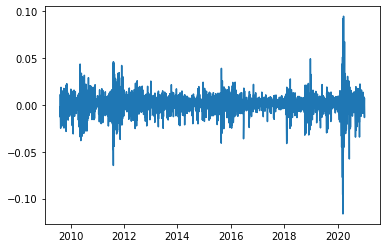

In [37]:
sp500_daily_returns.plot()

In [38]:
#calculate cumulative returns
cumulative_returns = (1+ sp500_daily_returns).cumprod()-1
cumulative_returns.head()

2009-08-07         NaN
2009-08-10   -0.002273
2009-08-11   -0.015120
2009-08-12   -0.004052
2009-08-13    0.003854
Name: close, dtype: float64

<AxesSubplot:title={'center':'Cumulative Returns of SP500 Since the Inception of Bitcoin'}>

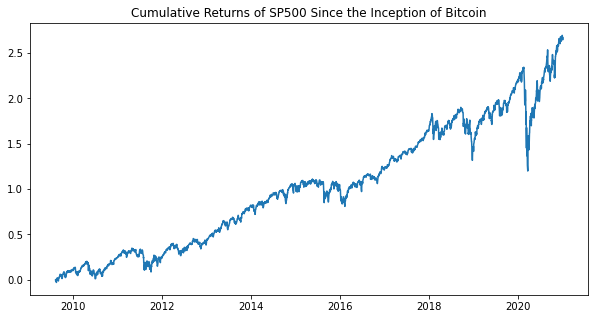

In [39]:
cumulative_returns.plot(figsize=(10,5), title="Cumulative Returns of SP500 Since the Inception of Bitcoin")

In [40]:
daily_std = sp500_daily_returns.std()
daily_std

0.01094760874361847

In [41]:
#calculate the annualized std(252 trading days)
annualized_std = daily_std*np.sqrt(252)
annualized_std

0.17378790111870446

In [43]:
# Calculate the rolling standard deviation for all portfolios using a 21-day window

rolling_std = sp500_daily_returns.rolling(window=21).std()
rolling_std

2009-08-07         NaN
2009-08-10         NaN
2009-08-11         NaN
2009-08-12         NaN
2009-08-13         NaN
                ...   
2020-12-29    0.005931
2020-12-30    0.005792
2020-12-31    0.005436
2021-01-04    0.006268
2021-01-05    0.006419
Name: close, Length: 2873, dtype: float64

<AxesSubplot:>

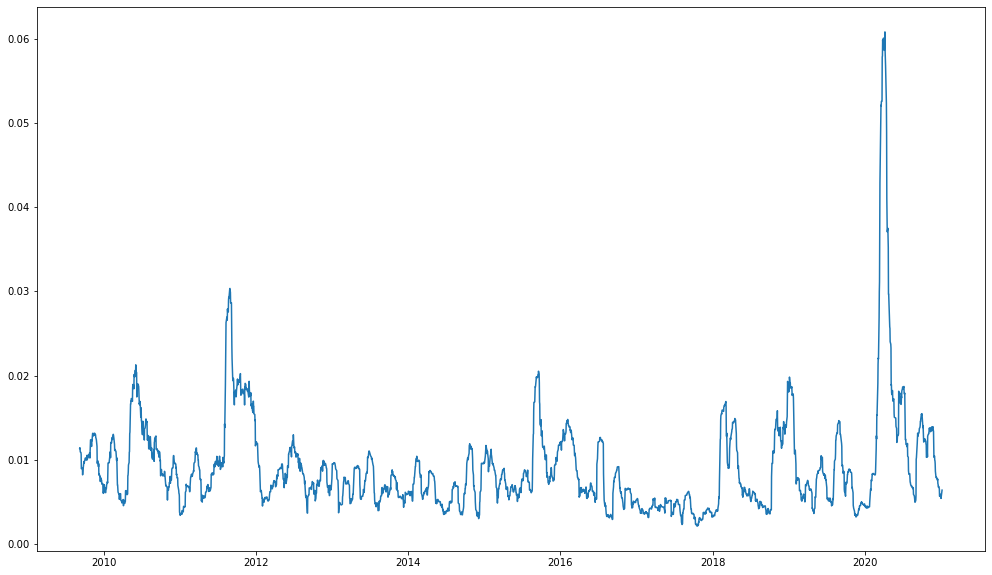

In [44]:
# Plot the rolling standard deviation
rolling_std.plot(figsize=[17,10])

In [ ]:
# Calculate the correlation
rolling_std_all.corr()

In [ ]:
# Display the correlation matrix
correlation = rolling_std.corr()
sns.heatmap(correlation, vmin=-1,vmax=1)